# imports

In [1]:
import numpy as np
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Основые функции

In [2]:
def nice_obj(u1, u2, m1):
    x = 0.8 * u2 + 0.4 * u1 + 0.05 * m1
    return x

def datasets_make_regression(func, count_dots, random_state, dispersion, border):

    np.random.seed(random_state)
    x1 = np.linspace(border[0,0], border[0,1], count_dots)
    u1 = np.sin(x1*0.5) + np.random.normal(0,dispersion,len(x1))

    x2 = np.linspace(border[1,0], border[1,1], count_dots)
    u2 = np.power(x2, 1/2) + np.random.normal(0,dispersion,len(x2))
    #u2 = x2 + np.random.normal(0,dispersion,len(x2))

    x3 = np.linspace(border[2,0], border[2,1], count_dots)
    m1 = np.cos(0.3 * x3) + np.random.normal(0,dispersion,len(x3))

    y = func(u1,u2,m1) + np.random.normal(0,dispersion,len(x3))

    return u1, u2, m1, y

In [3]:
def nuke_Epa(x):
    if (abs(x) <= 1):
        return 3/4 * (1-x**2)
    else:
        return 0

In [201]:
def u1_regression(X_want, m_pred, x_train, u_train, m_train, par_blur, nuke):
# x_train - тренировочные значения переменных
# par_blur - зачения параметра размытости [значение параметра для X, значение параметра для m]
# nuke - ссылка на ядерную функцию
# m_pred - последнее значение неуправляемой переменной
# X_want - желаемое значение X
# В итоге может получится значение NaN. В этом случае парметр размытости не подходит. На выходе: предстказанное значение функции в координатах X_pred
    up = 0
    down = 0
    size = len(x_train)
    #print(f'{np.shape(x_train)=}    {np.shape(u_train)=}    {np.shape(m_train)=}')
    # запускаем оценку
    for i in range(size):
        down+= nuke( (X_want - x_train[i])/par_blur['x']) * nuke( (m_pred - m_train[i])/par_blur['m1'])
        up += u_train[i] * nuke( (X_want - x_train[i])/par_blur['x']) * nuke( (m_pred - m_train[i])/par_blur['m1'])
    if down == 0: return 0 # точка за границами обучающей выборки
    return up/down

def u_2_regression(X_want,U_1_pred, m_pred, x_train, u2_train, u1_train, m_train, par_blur, nuke):
# x_train - тренировочные значения переменных
# par_blur - зачения параметра размытости [значение параметра для X, значение параметра для m, значение параметра для u1]
# nuke - ссылка на ядерную функцию
# u2_train - тренировочные значения для u2
# u1_train - тренировочные значения для u1
# U_1_pred - предсказанное на предыдущем шаге значение u1
# m_pred - последнее значение неуправляемой переменной
# X_want - желаемое значение X
# В итоге может получится значение NaN. В этом случае парметр размытости не подходит. На выходе: предстказанное значение функции в координатах X_pred
    up = 0
    down = 0
    size = len(x_train)
    for i in range(size):
        down += nuke( (X_want - x_train[i])/par_blur['x']) * nuke( (m_pred - m_train[i])/par_blur['m1']) * nuke( (U_1_pred - u1_train[i])/par_blur['u1'])
        up += u2_train[i] * nuke( (X_want - x_train[i])/par_blur['x']) * nuke( (m_pred - m_train[i])/par_blur['m1']) * nuke( (U_1_pred - u1_train[i])/par_blur['u1'])
    if down == 0: return 0 # точка за границами обучающей выборки
    return up/down

def outside_m(m,delta_m,dispersion):  
    m1 = np.cos(0.3 * (m+delta_m)) + np.random.normal(0,dispersion)
    return m1

def catch_train_sample(train,X,par_blur):
    k = 1
    mask = (train > (X-k*par_blur)) & (train < (X+k*par_blur))
    sample = train[mask]
    return sample

def find_borders(train, dot, blur):
    k = 0.2
    maxi = train[ np.argmax(train) ]
    mini = train[ np.argmin(train) ]
    if dot > ( maxi + k*blur): return maxi + (k*0.5)*blur
    elif dot < ( mini + k*blur): return mini - (k*0.5)*blur
    else: return dot

# Генерация выборки

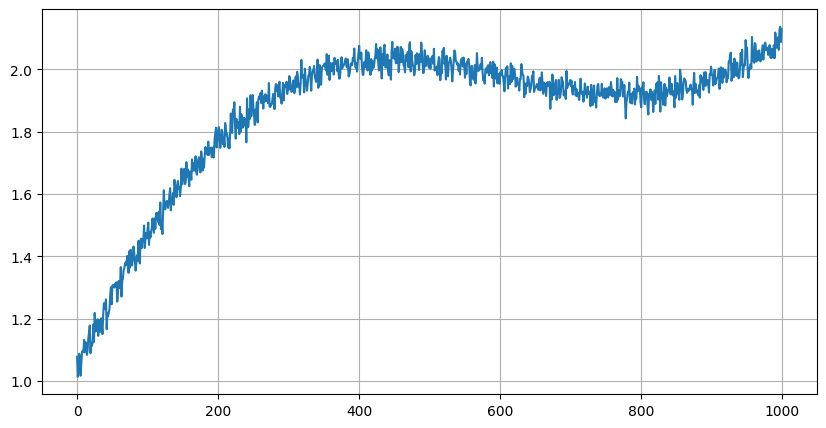

In [5]:
nuke = nuke_Epa
count_dots = 1000 # размер интервала разбиения генерируемого набора данных
noise_per = 0.15
random_state = 10
dispersion = 0.02
border = np.array([ [ 1, 10],
                    [ 1, 10],
                    [ 1, 10] ])

u1, u2, m1, x = datasets_make_regression(nice_obj, count_dots, random_state, dispersion, border)
data = pd.DataFrame()
data['X'] = x
data['u_1'] = u1
data['u_2'] = u2
data['m_1'] = m1
T = np.stack((u1,u2,m1),axis=1)

fig = plt.figure(figsize =(10, 5))
ax = plt.axes()
ax.plot(data['X'])
ax.grid()
plt.show()

# Работа над управлением

$u(t) = Kp * e(t)$,

где:

$u(t)$ — управляющее воздействие;
$Kp$ — коэффициент усиления регулятора;
$e(t)$ — ошибка регулирования.


$e(t)=x_{зад}(t)-x(t)$,

где:

$x_{зад}$ — заданное значение регулируемой величины,
$x$ — текущее значение регулируемой величины (предыдущее).


In [ ]:
def X_want_cos(x):
    return 2 + 0.3*np.cos(x/200)
def X_want_hevi(x):
    x = float(x)
    if (x<200): return -5
    elif(x<400): return 10
    elif(x<600): return 7
    else: return 5.5

## Проверка на функции косинуса

Среднеквадратическая ошибка: 0.0007044691626847464


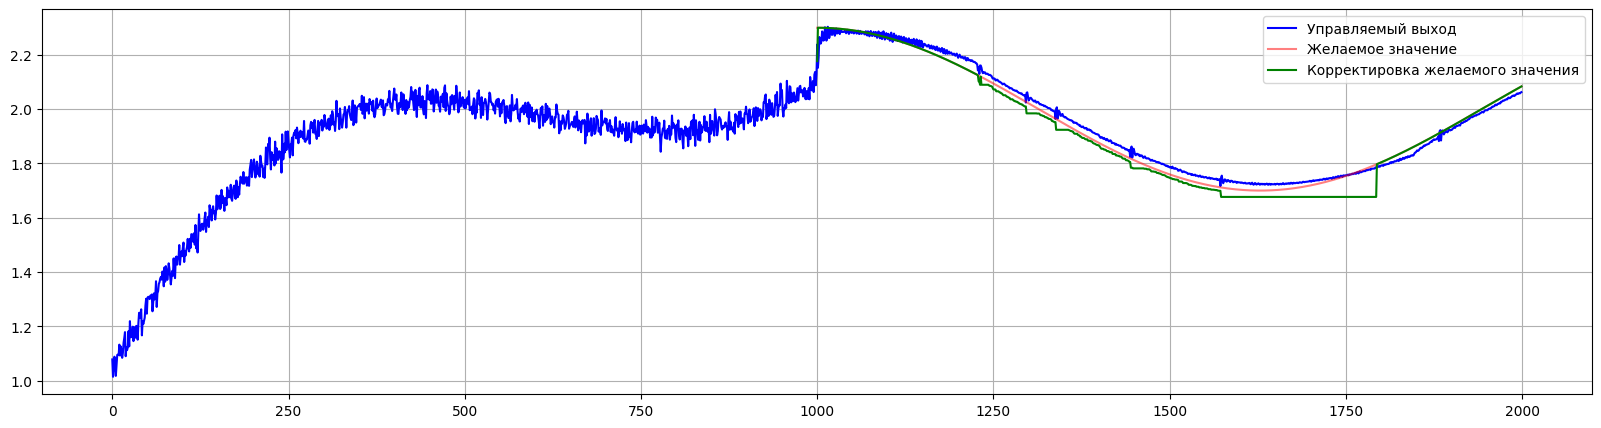

In [202]:
curr_nuke = nuke_Epa
u1, u2, m1, x = datasets_make_regression(nice_obj, count_dots, random_state, dispersion, border)
X_want = 5.8
X_func = X_want_cos
parameters_blur = { 'x'     : 0.4,      # зачения параметра размытости [значение параметра для X, значение параметра для m, значение параметра для u1, значение параметра для u2] последнее чтобы обрезать значение u2 для регулятора
                    'm1'    : 0.5,
                    'u1'    : 0.2,
                    'u2'    : 0.1,}
delta_m = 0.04382228452903661
K_p = 1.1 # коэффициент усиления регулятора
e = 0.0000 # ошибка регулирования
correction = 0.000001
difference = []
count_of_steps = 1000

for step in range(count_of_steps):
    sample_x = catch_train_sample(x,x[-1],parameters_blur['x'])
    sample_m1 = catch_train_sample(m1,m1[-1],parameters_blur['m1'])
    sample_u1 = catch_train_sample(u1,u1[-1],parameters_blur['u1'])
    sample_u2 = catch_train_sample( u2 , u2[-1] , parameters_blur['u2'] )

    # т. к. обучающие массивы обрезаны в результате кластеризации, то нужно подогнать их по размеру
    sizes = np.array([ np.shape(sample_x)[0], np.shape(sample_m1)[0], np.shape(sample_u1)[0], np.shape(sample_u2)[0] ]) 
    size = sizes[np.argmin(sizes)] 
    sample_x = sample_x[-size:]
    sample_u1 = sample_u1[-size:]
    sample_u2 = sample_u2[-size:]
    sample_m1 = sample_m1[-size:]


    X_want = X_func(step)
    #print(f'{step=}\n{X_want=}')
    correction = K_p * (X_want - x[-1])
    sample_m1 = np.append( sample_m1 , outside_m(sample_m1[-1],delta_m, dispersion) )
    X_want = find_borders(sample_x, X_want, parameters_blur['x'])
    u_1_next = u1_regression(X_want = X_want, m_pred = sample_m1[-1], x_train = sample_x, u_train = sample_u1, m_train = sample_m1, par_blur=parameters_blur, nuke=curr_nuke)        # возможно надо обрезать m1, чтобы был без последнего элемента
    if (np.isnan(u_1_next)):
        print(f'u1 bed par blur     {step=} {X_want=}')
        u_1_next = 0
        #break
    u_1_next += correction
    u_1_next = find_borders(sample_u1, u_1_next, parameters_blur['u1'])
    sample_u1 = np.append(sample_u1, u_1_next)
    u_2_next = u_2_regression(X_want = X_want,U_1_pred = u_1_next, m_pred = sample_m1[-1], x_train = sample_x, u2_train=sample_u2, u1_train=sample_u1, m_train=sample_m1, par_blur = parameters_blur, nuke = curr_nuke)
    if (np.isnan(u_2_next)):
        print(f'u2 bed par blur     {step=} {X_want=}')
        u_2_next = 0
        #break
    u_2_next += correction
    u_2_next = find_borders(sample_u2, u_2_next, parameters_blur['u2'])
    sample_u2 = np.append(sample_u2, u_2_next)
    X_currend = nice_obj(sample_u1[-1], u2[-1], sample_m1[-1])
    difference.append([ step, X_want, correction**2 ])
    x = np.append( x, X_currend )
    u1 = np.append( u1, sample_u1[-1] )
    u2 = np.append( u2, sample_u2[-1] )
    m1 = np.append( m1, sample_m1[-1] )

difference = np.array(difference)
print(f'Среднеквадратическая ошибка: {difference[:,2].sum()/count_of_steps}')

true_pic = []
for i in range(step+1):
    true_pic.append(X_func(i))

fig = plt.figure(figsize =(20, 5))
ax = plt.axes()
ax.plot(list(range(len(x))),x,color="blue",label='Управляемый выход')
ax.plot(1000+difference[:,0],true_pic,color='red', alpha = 0.5, label='Желаемое значение')
ax.plot(1000+difference[:,0],difference[:,1],color='green', label='Корректировка желаемого значения')
ax.legend()
ax.grid()
plt.show()

## Проверка на ступенчатой функции

Среднеквадратическая ошибка: 0.640683755182391


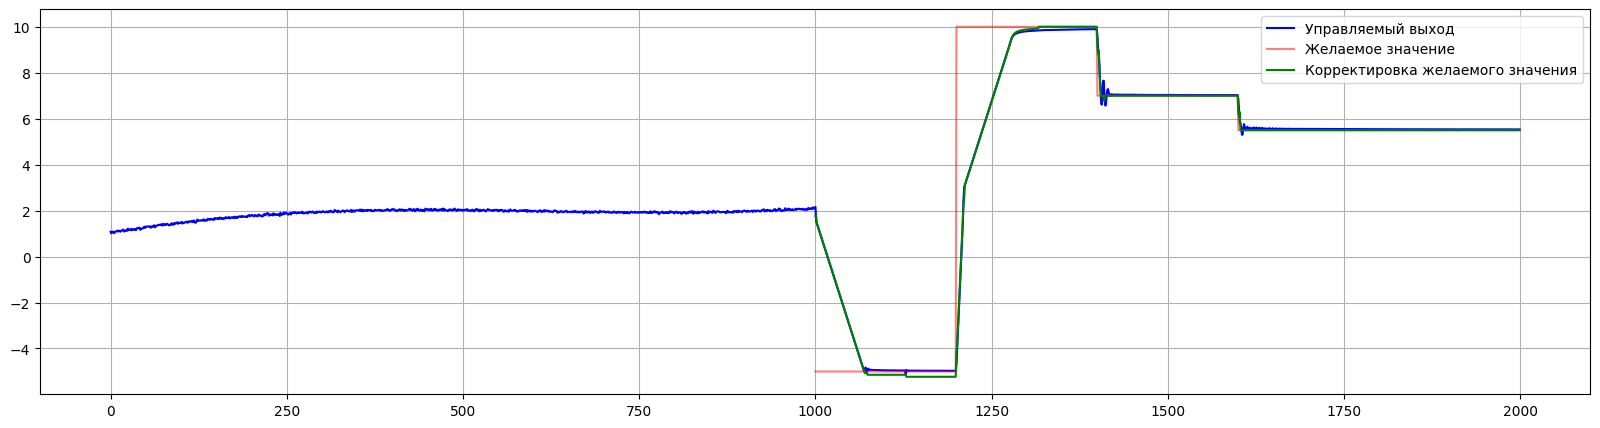

In [199]:
curr_nuke = nuke_Epa
u1, u2, m1, x = datasets_make_regression(nice_obj, count_dots, random_state, dispersion, border)
X_want = 5.8
X_func = X_want_hevi
parameters_blur = { 'x'     : 0.8,      # зачения параметра размытости [значение параметра для X, значение параметра для m, значение параметра для u1, значение параметра для u2] последнее чтобы обрезать значение u2 для регулятора
                    'm1'    : 0.8,
                    'u1'    : 0.8,
                    'u2'    : 0.8,}
delta_m = 0.04382228452903661
K_p = 0.4 # коэффициент усиления регулятора
e = 0.0000 # ошибка регулирования
correction = 0.000001
difference = []
count_of_steps = 1000

for step in range(count_of_steps):
    sample_x = catch_train_sample(x,x[-1],parameters_blur['x'])
    sample_m1 = catch_train_sample(m1,m1[-1],parameters_blur['m1'])
    sample_u1 = catch_train_sample(u1,u1[-1],parameters_blur['u1'])
    sample_u2 = catch_train_sample( u2 , u2[-1] , parameters_blur['u2'] )

    # т. к. обучающие массивы обрезаны в результате кластеризации, то нужно подогнать их по размеру
    sizes = np.array([ np.shape(sample_x)[0], np.shape(sample_m1)[0], np.shape(sample_u1)[0], np.shape(sample_u2)[0] ]) 
    size = sizes[np.argmin(sizes)] 
    sample_x = sample_x[-size:]
    sample_u1 = sample_u1[-size:]
    sample_u2 = sample_u2[-size:]
    sample_m1 = sample_m1[-size:]


    X_want = X_func(step)
    #print(f'{step=}\n{X_want=}')
    correction = K_p * (X_want - x[-1])
    sample_m1 = np.append( sample_m1 , outside_m(sample_m1[-1],delta_m, dispersion) )
    X_want = find_borders(sample_x, X_want, parameters_blur['x'])
    u_1_next = u1_regression(X_want = X_want, m_pred = sample_m1[-1], x_train = sample_x, u_train = sample_u1, m_train = sample_m1, par_blur=parameters_blur, nuke=curr_nuke)        # возможно надо обрезать m1, чтобы был без последнего элемента
    if (np.isnan(u_1_next)):
        print(f'u1 bed par blur     {step=} {X_want=}')
        u_1_next = 0
        #break
    u_1_next += correction
    u_1_next = find_borders(sample_u1, u_1_next, parameters_blur['u1'])
    sample_u1 = np.append(sample_u1, u_1_next)
    u_2_next = u_2_regression(X_want = X_want,U_1_pred = u_1_next, m_pred = sample_m1[-1], x_train = sample_x, u2_train=sample_u2, u1_train=sample_u1, m_train=sample_m1, par_blur = parameters_blur, nuke = curr_nuke)
    if (np.isnan(u_2_next)):
        print(f'u2 bed par blur     {step=} {X_want=}')
        u_2_next = 0
        #break
    u_2_next += correction
    u_2_next = find_borders(sample_u2, u_2_next, parameters_blur['u2'])
    sample_u2 = np.append(sample_u2, u_2_next)
    X_currend = nice_obj(sample_u1[-1], u2[-1], sample_m1[-1])
    difference.append([ step, X_want, correction**2 ])
    x = np.append( x, X_currend )
    u1 = np.append( u1, sample_u1[-1] )
    u2 = np.append( u2, sample_u2[-1] )
    m1 = np.append( m1, sample_m1[-1] )

difference = np.array(difference)
print(f'Среднеквадратическая ошибка: {difference[:,2].sum()/count_of_steps}')

true_pic = []
for i in range(step+1):
    true_pic.append(X_func(i))

fig = plt.figure(figsize =(20, 5))
ax = plt.axes()
ax.plot(list(range(len(x))),x,color="blue",label='Управляемый выход')
ax.plot(1000+difference[:,0],true_pic,color='red', alpha = 0.5, label='Желаемое значение')
ax.plot(1000+difference[:,0],difference[:,1],color='green', label='Корректировка желаемого значения')
ax.legend()
ax.grid()
plt.show()